In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import calmap
import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

import time


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [37]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
test  = pd.read_csv('./input/test.csv').set_index('ID')

# 1. EDA

## 1.1 Items Table

In [38]:
train_items = pd.merge(train, items, on=['item_id'], how='left')

Text(0.5, 1.0, 'Top 15 Best Selling Items')

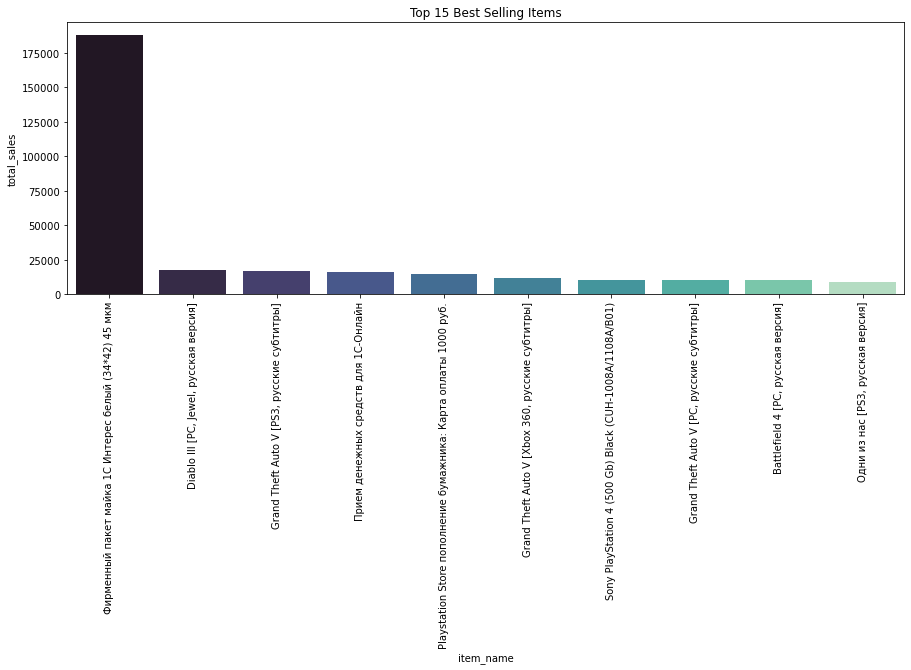

In [23]:
df_top_items=train_items.groupby(['item_name'],as_index=False)['item_cnt_day'].sum().\
sort_values('item_cnt_day',ascending=False).head(10)
df_top_items.columns=['item_name','total_sales']

x=df_top_items.item_name
y=df_top_items.total_sales
plt.figure(figsize = (15, 5))
ax = sns.barplot(x=x, y=y, palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top 15 Best Selling Items")

In [118]:
df_top_items

,item_name,item_cnt_day
20602,Фирменный пакет майка 1С Интерес белый (34*42)...,187642.0
2749,"Diablo III [PC, Jewel, русская версия]",17245.0
3654,"Grand Theft Auto V [PS3, русские субтитры]",16642.0
17418,Прием денежных средств для 1С-Онлайн,15830.0
5717,Playstation Store пополнение бумажника: Карта ...,14515.0
3656,"Grand Theft Auto V [Xbox 360, русские субтитры]",11688.0
6543,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,10289.0
3653,"Grand Theft Auto V [PC, русские субтитры]",10099.0
1814,"Battlefield 4 [PC, русская версия]",10032.0
16493,"Одни из нас [PS3, русская версия]",9227.0


In [56]:
items.drop(['item_name'], axis=1, inplace=True)

## 1.2 Categories Table

In [39]:
cats["isVideoGame"] = cats["item_category_name"].apply(lambda x: True if 'PS'in x or 'XBOX'in x else False)
cats[cats["isVideoGame"] == True]

,item_category_name,item_category_id,isVideoGame
1,Аксессуары - PS2,1,True
2,Аксессуары - PS3,2,True
3,Аксессуары - PS4,3,True
4,Аксессуары - PSP,4,True
5,Аксессуары - PSVita,5,True
6,Аксессуары - XBOX 360,6,True
7,Аксессуары - XBOX ONE,7,True
10,Игровые консоли - PS2,10,True
11,Игровые консоли - PS3,11,True
12,Игровые консоли - PS4,12,True


In [40]:
train_items_cats = pd.merge(train_items, cats, on=['item_category_id'], how='left')
train_items_cats

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,isVideoGame
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,False
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,False
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,False
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,False
2935845,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,False
2935846,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,False
2935847,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,False


Text(0.5, 1.0, 'Top 15 Best Selling Categories')

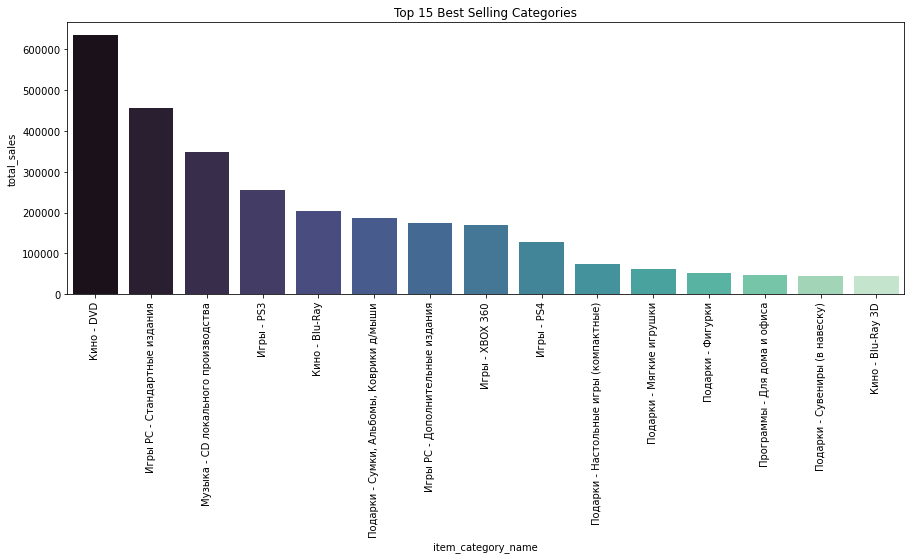

In [23]:
all_cats_sales=train_items_cats.groupby(['item_category_name'],as_index=False)['item_cnt_day']\
.sum().sort_values('item_cnt_day',ascending=False).head(15)
all_cats_sales.columns=['item_category_name','total_sales']
x=all_cats_sales.item_category_name
y=all_cats_sales.total_sales
plt.figure(figsize = (15, 5))
ax = sns.barplot(x=x, y=y, palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top 15 Best Selling Categories")

In [24]:
all_cats_sales

,item_category_name,total_sales
40,Кино - DVD,634171.0
30,Игры PC - Стандартные издания,456540.0
55,Музыка - CD локального производства,348591.0
19,Игры - PS3,254887.0
37,Кино - Blu-Ray,203284.0
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",187998.0
28,Игры PC - Дополнительные издания,174954.0
23,Игры - XBOX 360,169944.0
20,Игры - PS4,127319.0
65,Подарки - Настольные игры (компактные),73077.0


Text(0.5, 1.0, 'All Video Games Sales')

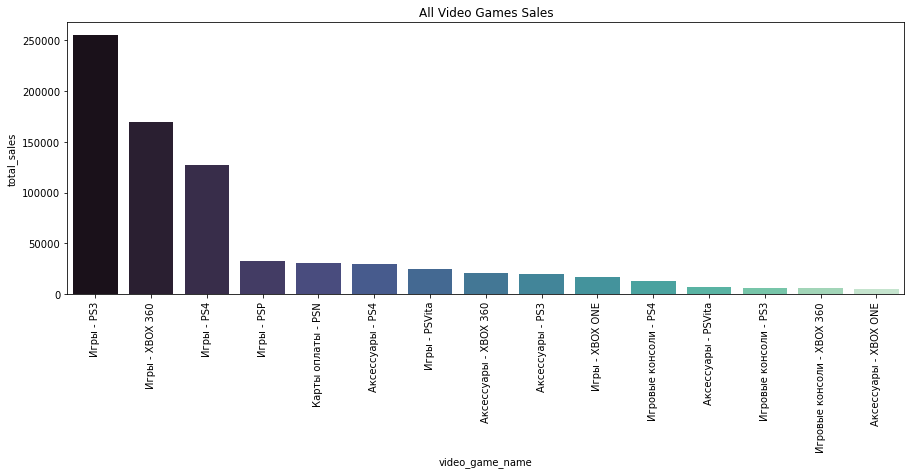

In [18]:
top_VG_sales=train_items_cats[train_items_cats['isVideoGame']==True].groupby(['item_category_name'],as_index=False)['item_cnt_day']\
.sum().sort_values('item_cnt_day',ascending=False).head(15)
top_VG_sales.columns=['video_game_name','total_sales']
x=top_VG_sales.video_game_name
y=top_VG_sales.total_sales
plt.figure(figsize = (15, 5))
ax = sns.barplot(x=x, y=y, palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("All Video Games Sales")

In [20]:
top_VG_sales

,video_game_name,total_sales
15,Игры - PS3,254887.0
19,Игры - XBOX 360,169944.0
16,Игры - PS4,127319.0
17,Игры - PSP,33066.0
21,Карты оплаты - PSN,31244.0
2,Аксессуары - PS4,29807.0
18,Игры - PSVita,25123.0
5,Аксессуары - XBOX 360,20472.0
1,Аксессуары - PS3,19597.0
20,Игры - XBOX ONE,16886.0


In [ ]:
cats['type'] = cats.item_category_name.str.split('-').apply(lambda x:x[0].strip())
cats['type_code']=LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats.item_category_name.str.split('-').apply(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
cats['subtype_code']=LabelEncoder().fit_transform(cats['subtype'])
cats.drop(['item_category_name','type','subtype'], axis=1, inplace=True)

## 1.3 Shops Table

In [148]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [42]:
train_items_cats_shops = pd.merge(train_items_cats, shops, on=['shop_id'], how='left')
train_items_cats_shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,isVideoGame,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,False,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,False,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум"""
2935845,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум"""
2935846,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум"""
2935847,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,False,"Москва ТРК ""Атриум"""


Text(0.5, 1.0, 'Most Popular Shops')

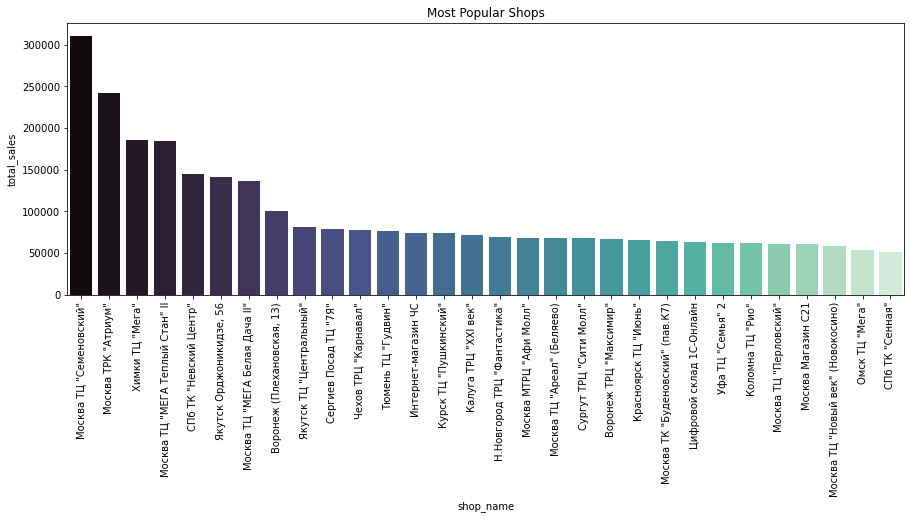

In [161]:
top_shops=train_items_cats_shops.groupby(['shop_name'],as_index=False)['item_cnt_day']\
.sum().sort_values('item_cnt_day',ascending=False).head(30)
top_shops.columns=['shop_name','total_sales']
x=top_shops.shop_name
y=top_shops.total_sales
plt.figure(figsize = (15, 5))
ax = sns.barplot(x=x, y=y, palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Most Popular Shops")

In [154]:
top_shops

,shop_name,total_sales
31,"Москва ТЦ ""Семеновский""",310777.0
25,"Москва ТРК ""Атриум""",241920.0
54,"Химки ТЦ ""Мега""",185790.0
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",184557.0
42,"СПб ТК ""Невский Центр""",144934.0
57,"Якутск Орджоникидзе, 56",141107.0
27,"Москва ТЦ ""МЕГА Белая Дача II""",136657.0
6,"Воронеж (Плехановская, 13)",100489.0
58,"Якутск ТЦ ""Центральный""",81734.0
46,"Сергиев Посад ТЦ ""7Я""",78990.0


In [43]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops.shop_name.str.split(' ').apply(lambda x:x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])


In [44]:
shops_city=shops[['shop_id','city']]
train_items_cats_shops_city = pd.merge(train_items_cats_shops, shops_city, on=['shop_id'], how='left')
train_items_cats_shops_city

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,isVideoGame,shop_name,city
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,False,"Ярославль ТЦ ""Альтаир""",Ярославль
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум""",Москва
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум""",Москва
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,False,"Москва ТРК ""Атриум""",Москва
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,False,"Москва ТРК ""Атриум""",Москва
...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум""",Москва
2935845,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум""",Москва
2935846,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,False,"Москва ТРК ""Атриум""",Москва
2935847,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,False,"Москва ТРК ""Атриум""",Москва


Text(0.5, 1.0, 'Top 10 Cities ')

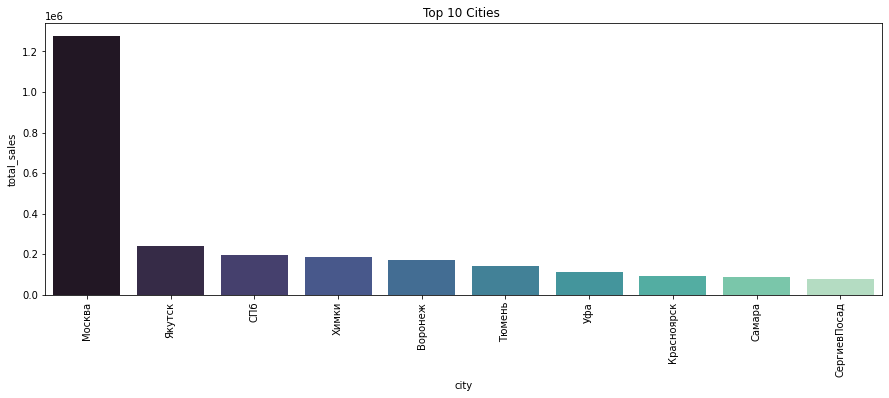

In [184]:
top_cities=train_items_cats_shops_city.groupby(['city'],as_index=False)['item_cnt_day']\
.sum().sort_values('item_cnt_day',ascending=False).head(10)
top_cities.columns=['city','total_sales']
x=top_cities.city
y=top_cities.total_sales
plt.figure(figsize = (15, 5))
ax = sns.barplot(x=x, y=y, palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Top 10 Cities ")

In [185]:
top_cities

,city,total_sales
13,Москва,1276376.0
29,Якутск,240857.0
19,СПб,195542.0
26,Химки,185790.0
4,Воронеж,171142.0
24,Тюмень,142095.0
25,Уфа,111401.0
11,Красноярск,91324.0
20,Самара,86833.0
21,СергиевПосад,78990.0


In [ ]:
shops.drop(['shop_name','city'], axis=1, inplace=True)

## 1.4 sales_train table

#### item_cnt_day&item_price

In [59]:
train["date"] = pd.to_datetime(train["date"], format = "%d.%m.%Y")
train["Year"] = train["date"].dt.year
train["Month"] = train["date"].dt.month

In [66]:
train.Year.unique()

array([2013, 2014, 2015], dtype=int64)

In [77]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10


In [75]:
train.groupby(['Year','Month'],as_index=False).agg({'item_cnt_day':'size'}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
Year,2013,2013,2013,2013,2013,2013,2013,2013,2013,2013,2013,2013,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
Month,1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10
item_cnt_day,115690,108613,121347,94109,91759,100403,100548,104772,96137,94202,96736,143246,99349,89830,92733,77906,78529,82408,78760,86614,73157,79361,86428,130786,88522,71808,69977,56274,54548,54617,55549,57029,50588,53514


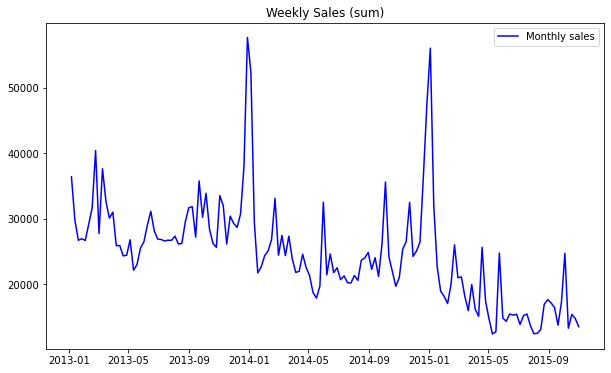

In [54]:
x = train[["date", "item_cnt_day"]].set_index("date").resample("W").sum()

plt.figure(figsize = (10, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Weekly Sales (sum)")
plt.legend();

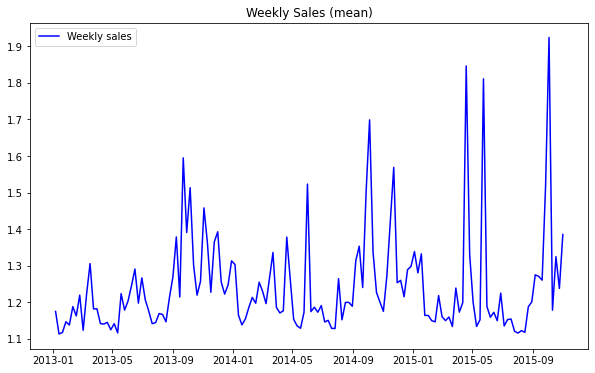

In [55]:
x = train[["date", "item_cnt_day"]].set_index("date").resample("W").mean()

plt.figure(figsize = (10, 6))
plt.plot(x, color = "blue", label = "Weekly sales")
plt.title("Weekly Sales (mean)")
plt.legend();

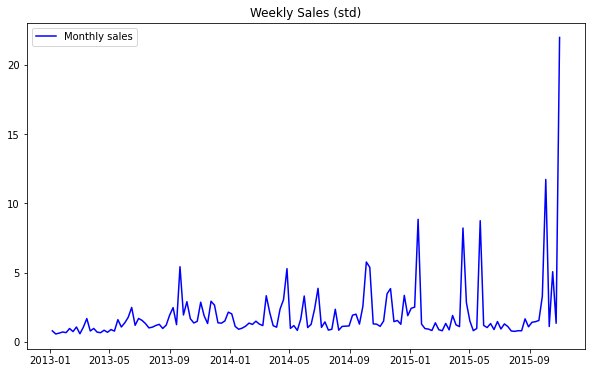

In [56]:
x = train[["date", "item_cnt_day"]].set_index("date").resample("W").std()

plt.figure(figsize = (10, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Weekly Sales (std)")
plt.legend();

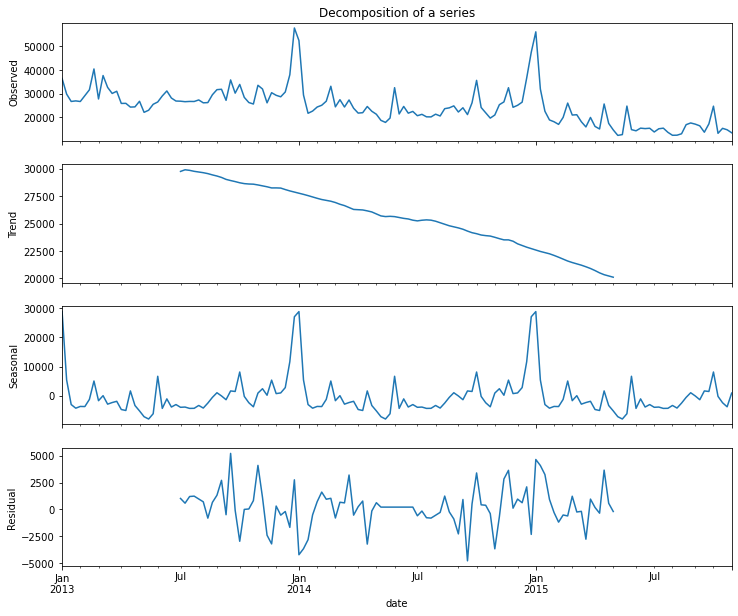

In [206]:
df_timeindex = train.set_index("date").resample("W")["item_cnt_day"].sum().to_frame()

result = seasonal_decompose(df_timeindex["item_cnt_day"])

fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))


# plot the original data
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = df_timeindex.index.tolist()

# set x_ticks
ax.set_xticks(xtick_location);

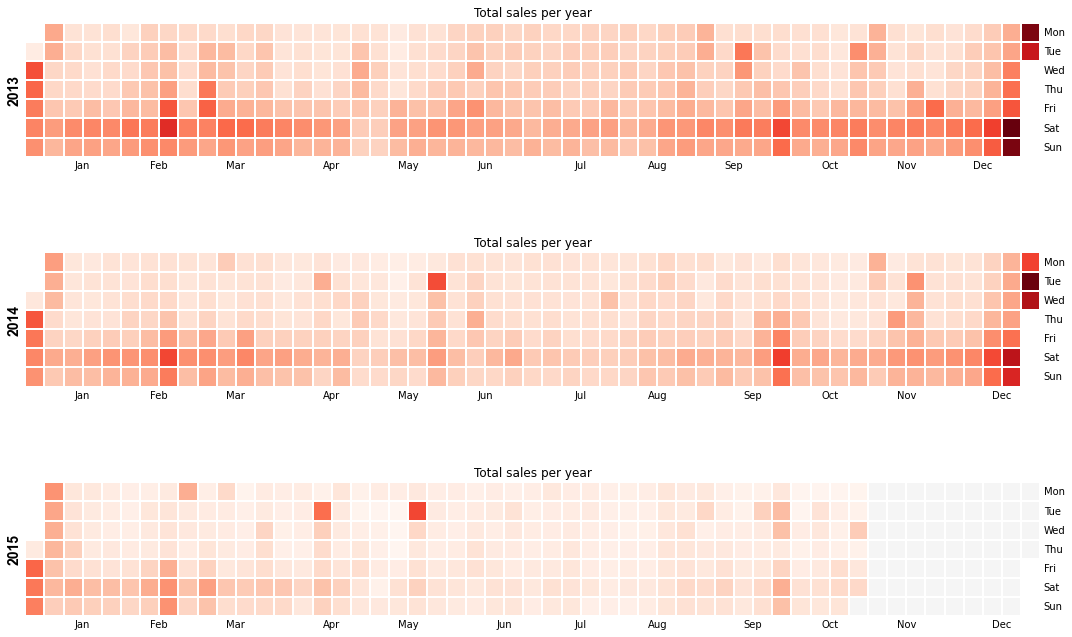

In [166]:
df_calendar = train[["date", "item_cnt_day"]].set_index("date").resample("D")["item_cnt_day"].sum()

calmap.calendarplot(df_calendar, # pass the series
                    fig_kws = {'figsize': (15,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

In [43]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10


C:\Users\Zack\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x288 with 0 Axes>

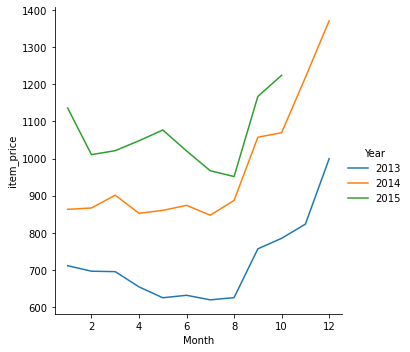

In [53]:
plt.figure(figsize=(15,4))
ax = sns.FacetGrid(data = df_price.sort_values(by="Month"), hue = "Year", size = 5, legend_out=True)
ax = ax.map(plt.plot, "Month", "item_price")
ax.add_legend()


In [81]:
train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

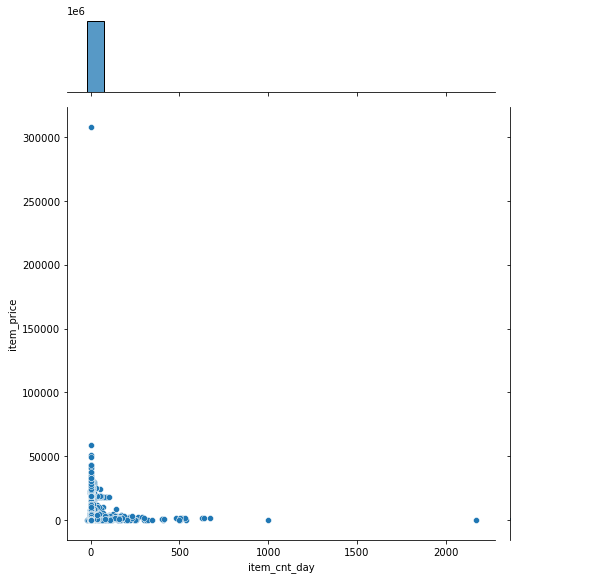

In [170]:
sns.jointplot(x="item_cnt_day", y="item_price", data=train_items_cats_shops, height=8)
plt.show()

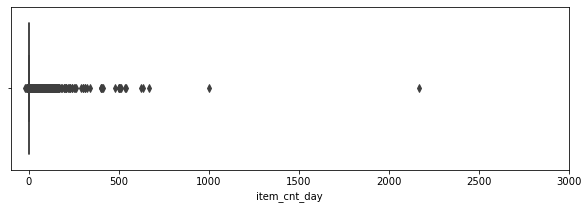

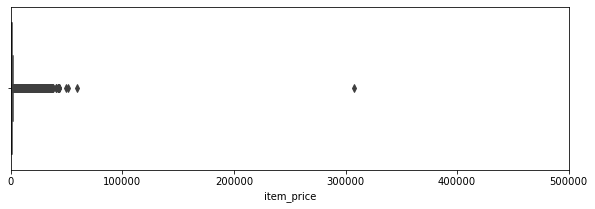

In [4]:
# Visualize the outliers
plt.figure(figsize=(10,3))
plt.xlim(-100,3000)
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10,3))
plt.xlim(-10, 500000)
sns.boxplot(x=train.item_price)

In [5]:
#Drop the outliers
train = train[(train.item_price<100000)&(train.item_cnt_day<1500)&(train.item_price>0)]

In [ ]:
train.loc[train['shop_id'] ==0, 'shop_id'] = 57
test.loc[test['shop_id'] ==0, 'shop_id'] = 57
train.loc[train['shop_id'] ==1, 'shop_id'] = 58
test.loc[test['shop_id'] ==1, 'shop_id'] = 58
train.loc[train['shop_id'] ==10, 'shop_id'] = 11
test.loc[test['shop_id'] ==10, 'shop_id'] = 11

## 1.5 Test Table

#### test contains 363 new item_id that train data doesn't have

In [85]:
test

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34


In [82]:
test.item_id.nunique()-len(set(test.item_id).intersection(set(train.item_id)))

363

#### test does not contain any new stores

In [83]:
test.shop_id.nunique()-len(set(test.shop_id).intersection(set(train.shop_id)))

0

#### Test table can be seen as the 34th month

In [84]:
test['date_block_num']=34

In [ ]:
test['date_block_num']=test['date_block_num'].astype(np.int8)
test['shop_id']=test['shop_id'].astype(np.int8)
test['item_id']=test['item_id'].astype(np.int16)

# 2. Feature Engineering

## 2.1 Matrix table
#### Create main table that holds all unique combination of 'date_block_num', 'shop_id' and 'item_id'. All feature engineering will be done on this table. 

In [11]:
matrix=[]

for i in range(34):
    df_i = train[train['date_block_num']==i]
    product_list = list(product(df_i.date_block_num.unique(), df_i.shop_id.unique(), df_i.item_id.unique()))
    matrix.append(product_list)
    
matrix=[i for j in matrix for i in j]

matrix=pd.DataFrame(matrix, columns=['date_block_num','shop_id','item_id'])

matrix.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

#### Get the total block(monthly) sales count for each unique block-shop-item combo 

In [12]:
df_block_cnt_sum = train.groupby(['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day': ['sum']})
df_block_cnt_sum.columns=['date_block_num','shop_id','item_id','item_cnt_block']
matrix=pd.merge(matrix, df_block_cnt_sum, on=['date_block_num','shop_id','item_id'], how='left')

#### Use clip to remove outliers

In [13]:
matrix['item_cnt_block']=matrix['item_cnt_block'].fillna(0).clip(0,20).astype(float)

#### Concatenate matrix table with test table
* Concatenating with test table ensures consistency. Data leakage will be avoided since all feature engineering are done based on 'date_block_num'. 

In [14]:
matrix=pd.concat([matrix,test],ignore_index=True, keys=['date_block_num','shop_id','item_id'])
matrix=matrix.fillna(0)

#### Join matrix table with other tables, shops, items and categories

In [15]:
matrix=pd.merge(matrix, shops, on=['shop_id'],how = 'left')
matrix=pd.merge(matrix, items, on=['item_id'],how = 'left')
matrix=pd.merge(matrix, cats, on=['item_category_id'],how = 'left')

## 2.2 Lag function

#### Create a 'fag function' that adds lag features based on input column and number of blocks to shift

In [25]:
def lag_func(df, i, col):

    temp = df[['date_block_num','shop_id','item_id',col]].copy()
    temp['date_block_num'] += i
    temp.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
    df = pd.merge(df, temp, on = ['date_block_num','shop_id','item_id'], how = 'left')
    
    return df

## 2.3 Lag features of mean values

#### Shift montly sales by 1,2 and 3 month 

In [17]:
%%time
matrix = lag_func(matrix, 1, 'item_cnt_block')
matrix = lag_func(matrix, 2, 'item_cnt_block')
matrix = lag_func(matrix, 3, 'item_cnt_block')

matrix['item_cnt_block_lag_1'] = matrix['item_cnt_block_lag_1'].astype(np.float16)
matrix['item_cnt_block_lag_2'] = matrix['item_cnt_block_lag_2'].astype(np.float16)
matrix['item_cnt_block_lag_3'] = matrix['item_cnt_block_lag_3'].astype(np.float16)

Wall time: 17.3 s


#### Calculate the mean and create lag features
#### Warning: this cell can take up to 10 minutes

In [19]:
%%time
matrix['mean_block_cnt']=matrix.groupby(['date_block_num'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_block_cnt')
matrix.drop(['mean_block_cnt'], axis=1, inplace=True)

matrix['mean_block_item_cnt']=matrix.groupby(['date_block_num', 'item_id'])['item_cnt_block'].transform('mean')
#for i in [1,2,3]:
matrix = lag_func(matrix, 1, 'mean_block_item_cnt')
matrix.drop(['mean_block_item_cnt'], axis=1, inplace=True)

matrix['mean_block_shop_cnt']=matrix.groupby(['date_block_num', 'shop_id'])['item_cnt_block'].transform('mean')
#for i in [1,2,3]:
matrix = lag_func(matrix, 1, 'mean_block_shop_cnt')
matrix.drop(['mean_block_shop_cnt'], axis=1, inplace=True)

matrix['mean_city_cnt']=matrix.groupby(['date_block_num', 'city_code'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_city_cnt')
matrix.drop(['mean_city_cnt'], axis=1, inplace=True)

matrix['mean_cat_cnt']=matrix.groupby(['date_block_num', 'item_category_id'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_cat_cnt')
matrix.drop(['mean_cat_cnt'], axis=1, inplace=True)

matrix['mean_type_cnt']=matrix.groupby(['date_block_num', 'type_code'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_type_cnt')
matrix.drop(['mean_type_cnt'], axis=1, inplace=True)

matrix['mean_subtype_cnt']=matrix.groupby(['date_block_num', 'subtype_code'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_subtype_cnt')
matrix.drop(['mean_subtype_cnt'], axis=1, inplace=True)

matrix['mean_shop_cat_cnt']=matrix.groupby(['date_block_num', 'shop_id','item_category_id'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_shop_cat_cnt')
matrix.drop(['mean_shop_cat_cnt'], axis=1, inplace=True)

matrix['mean_shop_type_cnt']=matrix.groupby(['date_block_num', 'shop_id','type_code'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_shop_type_cnt')
matrix.drop(['mean_shop_type_cnt'], axis=1, inplace=True)

matrix['mean_shop_subtype_cnt']=matrix.groupby(['date_block_num', 'shop_id','subtype_code'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_shop_subtype_cnt')
matrix.drop(['mean_shop_subtype_cnt'], axis=1, inplace=True)

matrix['mean_city_item_cnt']=matrix.groupby(['date_block_num', 'city_code','item_id'])['item_cnt_block'].transform('mean')
matrix = lag_func(matrix, 1, 'mean_city_item_cnt')
matrix.drop(['mean_city_item_cnt'], axis=1, inplace=True)

Wall time: 1min 30s


#### Run the memory reduction

In [6]:
# Run memory reduction
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix['item_cnt_block'] = matrix['item_cnt_block'].astype(np.float16)

matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

matrix['item_cnt_block_lag_1'] = matrix['item_cnt_block_lag_1'].astype(np.float16)
matrix['item_cnt_block_lag_2'] = matrix['item_cnt_block_lag_2'].astype(np.float16)
matrix['item_cnt_block_lag_3'] = matrix['item_cnt_block_lag_3'].astype(np.float16)

matrix['mean_block_cnt_lag_1'] = matrix['mean_block_cnt_lag_1'].astype(np.float16)
matrix['mean_block_item_cnt_lag_1'] = matrix['mean_block_item_cnt_lag_1'].astype(np.float16)

matrix['mean_block_shop_cnt_lag_1'] = matrix['mean_block_shop_cnt_lag_1'].astype(np.float16)

matrix['mean_city_cnt_lag_1'] = matrix['mean_city_cnt_lag_1'].astype(np.float16)
matrix['mean_cat_cnt_lag_1'] = matrix['mean_cat_cnt_lag_1'].astype(np.float16)
matrix['mean_type_cnt_lag_1'] = matrix['mean_type_cnt_lag_1'].astype(np.float16)
matrix['mean_subtype_cnt_lag_1'] = matrix['mean_subtype_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_cat_cnt_lag_1'] = matrix['mean_shop_cat_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_type_cnt_lag_1'] = matrix['mean_shop_type_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_subtype_cnt_lag_1'] = matrix['mean_shop_subtype_cnt_lag_1'].astype(np.float16)
matrix['mean_city_item_cnt_lag_1'] = matrix['mean_city_item_cnt_lag_1'].astype(np.float16)

## 2.4 Price trend features

#### Add a column that calculates each item's mean price

In [46]:
df_mean_item_price = train.groupby(['item_id'], as_index=False)['item_price'].mean()
df_mean_item_price.columns=['item_id','mean_item_price']
matrix = pd.merge(matrix, df_mean_item_price, on=['item_id'], how='left')

#### Calculate each item's mean price for every block every store. Then add a price delta column that shows the most recent price change

In [47]:
df_block_mean_item_price = train.groupby(['date_block_num','item_id'], as_index=False)['item_price'].mean()
df_block_mean_item_price.columns=['date_block_num','item_id','mean_block_item_price']
matrix = pd.merge(matrix, df_block_mean_item_price, on=['date_block_num','item_id'], how='left')

for i in [1,2,3]:
    matrix = lag_func(matrix, i, 'mean_block_item_price')

for i in [1,2,3]:
    matrix['mean_price_delta_lag_'+str(i)] =  (matrix['mean_block_item_price_lag_'+str(i)]-matrix['mean_item_price'])/matrix['mean_item_price']

In [48]:
def get_last_delta(row):
    for i in [1,2,3]:
        if row['mean_price_delta_lag_'+str(i)]:
            return row['mean_price_delta_lag_'+str(i)]
    return 0

In [49]:
matrix['recent_price_delta'] = matrix.apply(get_last_delta, axis=1)
matrix['recent_price_delta'].fillna(0, inplace=True)
matrix['recent_price_delta'] = matrix['recent_price_delta'].astype(np.float16)
matrix.drop(['mean_item_price','mean_block_item_price','mean_block_item_price_lag_1','mean_block_item_price_lag_2','mean_block_item_price_lag_3','mean_price_delta_lag_1','mean_price_delta_lag_2','mean_price_delta_lag_3'], axis=1, inplace=True)

In [62]:
matrix.to_csv('matrix_recent_delta.csv',index=False)

## 2.5 Shop monthly revenue

In [5]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

#### Calculate the total shop revenue in every month

In [19]:
df_block_shop_revenue = train.groupby(['date_block_num','shop_id'], as_index=False)['revenue'].sum()
df_block_shop_revenue.columns=['date_block_num','shop_id','block_shop_revenue']
matrix = pd.merge(matrix, df_block_shop_revenue, on=['date_block_num','shop_id'], how='left')

#### Calculate the average shop revenue and the price delta

In [ ]:
df_block_shop_revenue = df_block_shop_revenue.groupby(['shop_id'], as_index=False)['block_shop_revenue'].mean()
df_block_shop_revenue.columns=['shop_id','mean_shop_revenue']
matrix = pd.merge(matrix, df_block_shop_revenue, on=['shop_id'], how='left')

matrix['shop_revenue_delta'] = (matrix['block_shop_revenue'] - matrix['mean_shop_revenue']) / matrix['mean_shop_revenue']
matrix['shop_revenue_delta'] = matrix['shop_revenue_delta'].astype(np.float16)

matrix = lag_func(matrix, 1, 'shop_revenue_delta')

matrix.drop(['block_shop_revenue','mean_shop_revenue','shop_revenue_delta'], axis=1, inplace=True)


In [47]:
matrix.to_csv('matrix_revenue_delta.csv',index=False)

## 2.6 Item first sale 

#### For each item in each shop, find the month of first sale and months the item has been for sale

In [50]:
matrix['shop_item_first_sale']=matrix.groupby(['shop_id','item_id'])['date_block_num'].transform('min')
matrix['shop_item_since_first_sale']=matrix['date_block_num']-matrix['shop_item_first_sale']

#### For each item, find the month of first global sale and months since then

In [58]:
matrix['item_first_sale']=matrix.groupby(['item_id'])['date_block_num'].transform('min')
matrix['item_since_first_sale']=matrix['date_block_num']-matrix['item_first_sale']

In [101]:
matrix.drop(['shop_item_first_sale','item_first_sale'], axis=1, inplace=True)

In [104]:
matrix['month'] = matrix['date_block_num'] % 12
matrix['shop_item_since_first_sale'] = matrix['shop_item_since_first_sale'].astype(np.int8)
matrix['item_since_first_sale'] = matrix['item_since_first_sale'].astype(np.int8)
matrix['month'] = matrix['month'].astype(np.int8)

In [109]:
matrix.to_csv('matrix_revenue_month.csv',index=False)

In [126]:
matrix=pd.read_csv('matrix_revenue_month.csv')

In [203]:
matrix[matrix['item_cnt_block']==0].shape[0]/matrix.shape[0]

0.8557131180039116

# 3. Modelling

## 3.1 Fill NA values with 0

In [87]:
matrix

,date_block_num,shop_id,item_id,item_cnt_block,city_code,item_category_id,type_code,subtype_code,item_cnt_block_lag_1,item_cnt_block_lag_2,item_cnt_block_lag_3,mean_block_cnt_lag_1,mean_block_item_cnt_lag_1,mean_block_shop_cnt_lag_1,mean_city_cnt_lag_1,mean_cat_cnt_lag_1,mean_type_cnt_lag_1,mean_subtype_cnt_lag_1,mean_shop_cat_cnt_lag_1,mean_shop_type_cnt_lag_1,mean_shop_subtype_cnt_lag_1,mean_city_item_cnt_lag_1,recent_price_delta,shop_revenue_delta_lag_1,shop_item_since_first_sale,item_since_first_sale,month
0,0,2,19,0.0,0,40,11,4,0.0,0.0,0.0,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,0,0,0
1,0,2,27,1.0,0,19,5,10,0.0,0.0,0.0,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,0,0,0
2,0,2,28,0.0,0,30,8,55,0.0,0.0,0.0,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,0,0,0
3,0,2,29,0.0,0,23,5,16,0.0,0.0,0.0,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,0,0,0
4,0,2,32,0.0,0,40,11,4,0.0,0.0,0.0,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.2585,0.04544,0.1267,0.1354,0.1969,0.1470,0.1969,0.12680,0.08930,0.12680,0.5,-0.47530,-0.29,11,11,10
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,0.0,0.2585,0.02272,0.1267,0.1354,0.1559,0.2373,0.1559,0.09450,0.10620,0.09450,0.0,0.08120,-0.29,2,2,10
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.2585,0.11365,0.1267,0.1354,0.1969,0.1470,0.1969,0.12680,0.08930,0.12680,0.0,0.15590,-0.29,34,34,10
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.2585,0.04544,0.1267,0.1354,0.2208,0.2242,0.2208,0.08374,0.09705,0.08374,0.0,-0.09174,-0.29,11,11,10


In [114]:
col_fillna=['item_cnt_block_lag_1', \
            'item_cnt_block_lag_2',\
            'item_cnt_block_lag_3',\
            'mean_block_cnt_lag_1',\
            'mean_block_item_cnt_lag_1',\
            'mean_block_shop_cnt_lag_1',\
            'mean_city_cnt_lag_1',\
            'mean_cat_cnt_lag_1',\
            'mean_type_cnt_lag_1',\
            'mean_subtype_cnt_lag_1',\
            'mean_shop_cat_cnt_lag_1',\
            'mean_shop_type_cnt_lag_1',\
            'mean_shop_subtype_cnt_lag_1',\
            'mean_city_item_cnt_lag_1',\
            'shop_revenue_delta_lag_1']
matrix[col_fillna]=matrix[col_fillna].fillna(0) 

In [138]:
matrix.to_csv('matrix_fillna.csv',index=False)

In [86]:
matrix=pd.read_csv('matrix_fillna.csv')

In [5]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int64  
 1   shop_id                      int64  
 2   item_id                      int64  
 3   item_cnt_block               float64
 4   city_code                    int64  
 5   item_category_id             int64  
 6   type_code                    int64  
 7   subtype_code                 int64  
 8   item_cnt_block_lag_1         float64
 9   item_cnt_block_lag_2         float64
 10  item_cnt_block_lag_3         float64
 11  mean_block_cnt_lag_1         float64
 12  mean_block_item_cnt_lag_1    float64
 13  mean_block_shop_cnt_lag_1    float64
 14  mean_city_cnt_lag_1          float64
 15  mean_cat_cnt_lag_1           float64
 16  mean_type_cnt_lag_1          float64
 17  mean_subtype_cnt_lag_1       float64
 18  mean_shop_cat_cnt_lag_1      float64
 19

In [7]:
# Run memory reduction
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix['item_cnt_block'] = matrix['item_cnt_block'].astype(np.float16)

matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

matrix['item_cnt_block_lag_1'] = matrix['item_cnt_block_lag_1'].astype(np.float16)
matrix['item_cnt_block_lag_2'] = matrix['item_cnt_block_lag_2'].astype(np.float16)
matrix['item_cnt_block_lag_3'] = matrix['item_cnt_block_lag_3'].astype(np.float16)

matrix['mean_block_cnt_lag_1'] = matrix['mean_block_cnt_lag_1'].astype(np.float16)
matrix['mean_block_item_cnt_lag_1'] = matrix['mean_block_item_cnt_lag_1'].astype(np.float16)

matrix['mean_block_shop_cnt_lag_1'] = matrix['mean_block_shop_cnt_lag_1'].astype(np.float16)

matrix['mean_city_cnt_lag_1'] = matrix['mean_city_cnt_lag_1'].astype(np.float16)
matrix['mean_cat_cnt_lag_1'] = matrix['mean_cat_cnt_lag_1'].astype(np.float16)
matrix['mean_type_cnt_lag_1'] = matrix['mean_type_cnt_lag_1'].astype(np.float16)
matrix['mean_subtype_cnt_lag_1'] = matrix['mean_subtype_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_cat_cnt_lag_1'] = matrix['mean_shop_cat_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_type_cnt_lag_1'] = matrix['mean_shop_type_cnt_lag_1'].astype(np.float16)
matrix['mean_shop_subtype_cnt_lag_1'] = matrix['mean_shop_subtype_cnt_lag_1'].astype(np.float16)
matrix['mean_city_item_cnt_lag_1'] = matrix['mean_city_item_cnt_lag_1'].astype(np.float16)
matrix['recent_price_delta'] = matrix['recent_price_delta'].astype(np.float16)
matrix['shop_revenue_delta_lag_1'] = matrix['shop_revenue_delta_lag_1'].astype(np.float16)
matrix['shop_item_since_first_sale'] = matrix['shop_item_since_first_sale'].astype(np.int8)
matrix['item_since_first_sale'] = matrix['item_since_first_sale'].astype(np.int8)
matrix['month'] = matrix['month'].astype(np.int8)

In [8]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int8   
 1   shop_id                      int8   
 2   item_id                      int16  
 3   item_cnt_block               float16
 4   city_code                    int8   
 5   item_category_id             int8   
 6   type_code                    int8   
 7   subtype_code                 int8   
 8   item_cnt_block_lag_1         float16
 9   item_cnt_block_lag_2         float16
 10  item_cnt_block_lag_3         float16
 11  mean_block_cnt_lag_1         float16
 12  mean_block_item_cnt_lag_1    float16
 13  mean_block_shop_cnt_lag_1    float16
 14  mean_city_cnt_lag_1          float16
 15  mean_cat_cnt_lag_1           float16
 16  mean_type_cnt_lag_1          float16
 17  mean_subtype_cnt_lag_1       float16
 18  mean_shop_cat_cnt_lag_1      float16
 19

## 3.2 Feature Selection

In [9]:
df = matrix[matrix.date_block_num > 2]

In [10]:
df = df[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_block',
    #'city_code',
    'item_category_id',
    #'type_code',
    'subtype_code',
    'item_cnt_block_lag_1',
    'item_cnt_block_lag_2',
    'item_cnt_block_lag_3',
    'mean_block_cnt_lag_1',
    'mean_block_item_cnt_lag_1',
    'mean_block_shop_cnt_lag_1',
    #'mean_city_cnt_lag_1',
    'mean_cat_cnt_lag_1',
    'mean_type_cnt_lag_1',
    #'mean_subtype_cnt_lag_1',
    #'mean_shop_cat_cnt_lag_1',
    #'mean_shop_type_cnt_lag_1',
    #'mean_shop_subtype_cnt_lag_1',
    #'mean_city_item_cnt_lag_1',
    'recent_price_delta',
    'shop_revenue_delta_lag_1',
    'shop_item_since_first_sale',
    'item_since_first_sale',
    'month'
]]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005209 entries, 1122795 to 11128003
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date_block_num              int8   
 1   shop_id                     int8   
 2   item_id                     int16  
 3   item_cnt_block              float16
 4   item_category_id            int8   
 5   subtype_code                int8   
 6   item_cnt_block_lag_1        float16
 7   item_cnt_block_lag_2        float16
 8   item_cnt_block_lag_3        float16
 9   mean_block_cnt_lag_1        float16
 10  mean_block_item_cnt_lag_1   float16
 11  mean_block_shop_cnt_lag_1   float16
 12  mean_cat_cnt_lag_1          float16
 13  mean_type_cnt_lag_1         float16
 14  recent_price_delta          float16
 15  shop_revenue_delta_lag_1    float16
 16  shop_item_since_first_sale  int8   
 17  item_since_first_sale       int8   
 18  month                       int8   
dtypes: float16(11

In [12]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_block'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_block']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_block'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_block']
X_test = df[df.date_block_num == 34].drop(['item_cnt_block'], axis=1)

#### Use the last 6 months data for KNN, otherwise it will take too long

In [11]:
X_train_knn = df[(df.date_block_num < 33) & (df.date_block_num > 31)].drop(['item_cnt_block'], axis=1)
Y_train_knn = df[(df.date_block_num < 33) & (df.date_block_num > 31)]['item_cnt_block']
X_valid_knn = df[df.date_block_num == 33].drop(['item_cnt_block'], axis=1)
Y_valid_knn = df[df.date_block_num == 33]['item_cnt_block']

## 3.3 XGBoost

In [20]:
xgb_model = XGBRegressor(
    max_depth=10,
    n_estimators=500,
    min_child_weight=100, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42, 
    n_jobs=-1)

xgb_model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=1, 
    early_stopping_rounds = 5)


[10:55:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.17649	validation_1-rmse:1.11908
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.12750	validation_1-rmse:1.07936
[2]	validation_0-rmse:1.08439	validation_1-rmse:1.04846
[3]	validation_0-rmse:1.04968	validation_1-rmse:1.02231
[4]	validation_0-rmse:1.01931	validation_1-rmse:0.99962
[5]	validation_0-rmse:0.99456	validation_1-rmse:0.98253
[6]	validation_0-rmse:0.97099	validation_1-rmse:0.96729
[7]	validation_0-rmse:0.95350	validation_1-rmse:0.95535
[8]	validation_0-rmse:0.93685	validation_1-rmse:0.94603
[9]	validation_0-rmse:0.92341	validation_1-rmse:0.93819
[10]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=100, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

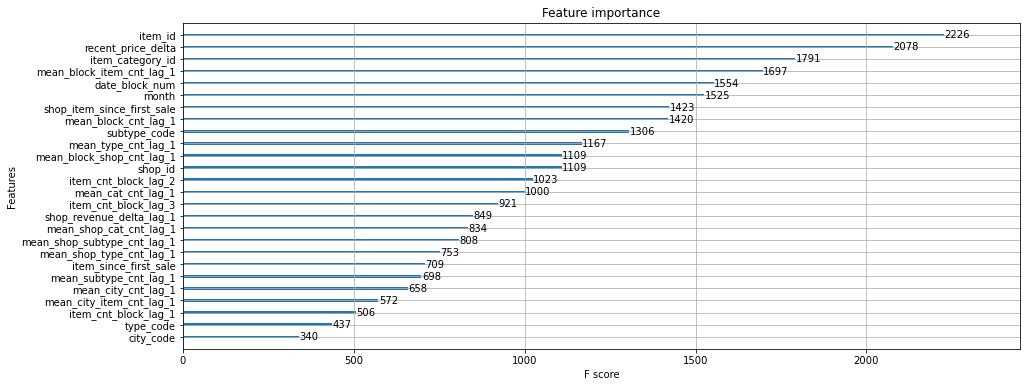

In [31]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(model)
plt.show()

## 3.4 Light GBM

In [43]:
lgbm_model = LGBMRegressor( 
    boosting_type="gbdt",
    objective='regression',
    metric='rmse',
    random_state=42, 
    n_estimators=50,
    num_leaves=32, 
    max_depth=8,
    feature_fraction=0.8,  
    bagging_fraction=0.8, 
    bagging_freq=15, 
    learning_rate=0.1,
    n_jobs=-1
)


xgb_model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=1, 
    early_stopping_rounds = 5)

[0]	validation_0-rmse:1.17569	validation_1-rmse:1.11889
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.12636	validation_1-rmse:1.07894
[2]	validation_0-rmse:1.08283	validation_1-rmse:1.04771
[3]	validation_0-rmse:1.04765	validation_1-rmse:1.02387
[4]	validation_0-rmse:1.01663	validation_1-rmse:1.00186
[5]	validation_0-rmse:0.99124	validation_1-rmse:0.98260
[6]	validation_0-rmse:0.96715	validation_1-rmse:0.96695
[7]	validation_0-rmse:0.94930	validation_1-rmse:0.95504
[8]	validation_0-rmse:0.93212	validation_1-rmse:0.94511
[9]	validation_0-rmse:0.91809	validation_1-rmse:0.93740
[10]	validation_0-rmse:0.90606	validation_1-rmse:0.93026
[11]	validation_0-rmse:0.89563	validation_1-rmse:0.92313
[12]	validation_0-rmse:0.88619	validation_1-rmse:0.91879
[13]	validation_0-rmse:0.87813	validation_1-rmse:0.91844
[14]	validation_0-rmse:0.87098	validation_1-rmse:0.915

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

## 3.5 Random Forest

In [13]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [19]:
y_train_predict=rf_model.predict(X_train)
y_val_predict=rf_model.predict(X_valid)

In [21]:
print('RF Train rmse:', np.sqrt(mean_squared_error(Y_train, y_train_predict)))
print('RF Validation rmse:', np.sqrt(mean_squared_error(Y_valid, y_val_predict)))

RF Train rmse: 0.8581980796218451
RF Validation rmse: 0.9338935871652083


## 3.6 KNN

In [24]:
knn_model = KNeighborsRegressor(n_neighbors=10, leaf_size=10, n_jobs=-1)
knn_model.fit(X_train_knn, Y_train_knn)

KNeighborsRegressor(leaf_size=10, n_jobs=-1, n_neighbors=10)

In [25]:
y_train_predict=knn_model.predict(X_train_knn)
y_val_predict=knn_model.predict(X_valid_knn)

In [27]:
print('RF Train rmse:', np.sqrt(mean_squared_error(Y_train_knn, y_train_predict)))
print('RF Validation rmse:', np.sqrt(mean_squared_error(Y_valid_knn, y_val_predict)))

RF Train rmse: 0.6621898949918005
RF Validation rmse: 1.030820804257738


In [28]:
knn_model2 = KNeighborsRegressor(n_neighbors=5, leaf_size=10, n_jobs=-1)
knn_model2.fit(X_train_knn, Y_train_knn)

KNeighborsRegressor(leaf_size=10, n_jobs=-1)

In [29]:
y_train_predict2=knn_model2.predict(X_train_knn)
y_val_predict2=knn_model2.predict(X_valid_knn)

In [30]:
print('RF Train rmse:', np.sqrt(mean_squared_error(Y_train_knn, y_train_predict2)))
print('RF Validation rmse:', np.sqrt(mean_squared_error(Y_valid_knn, y_val_predict2)))

RF Train rmse: 0.5973278762772514
RF Validation rmse: 1.0472789704079923


## 3.7 Linear Regression

In [34]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, Y_train)

LinearRegression(n_jobs=-1)

In [35]:
y_train_predict=rf_model.predict(X_train)
y_val_predict=rf_model.predict(X_valid)

In [36]:
print('RF Train rmse:', np.sqrt(mean_squared_error(Y_train, y_train_predict)))
print('RF Validation rmse:', np.sqrt(mean_squared_error(Y_valid, y_val_predict)))

RF Train rmse: 0.8581980796218451
RF Validation rmse: 0.9338935871652083


## 3.8 Stacking

In [13]:
lgbm_model = LGBMRegressor( 
    boosting_type="gbdt",
    objective='regression',
    metric='rmse',
    random_state=42, 
    n_estimators=50,
    num_leaves=32, 
    max_depth=8,
    feature_fraction=0.8,  
    bagging_fraction=0.8, 
    bagging_freq=15, 
    learning_rate=0.1,
    n_jobs=-1
)

lr_model = LinearRegression(n_jobs=-1)

rf_model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)

xgb_model = XGBRegressor(
    max_depth=10,
    n_estimators=500,
    min_child_weight=10, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42, 
    n_jobs=-1)

In [14]:
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgbm_model),
    ('lr', lr_model)
]

stack_model = StackingRegressor(
    estimators=estimators, final_estimator=lr_model, verbose=2, n_jobs=-1
)

In [ ]:
stack_model.fit(X_train, Y_train)

In [15]:
y_train_predict=stack_model.predict(X_train_knn)
y_val_predict=stack_model.predict(X_valid_knn)

In [17]:
print('RF Train rmse:', np.sqrt(mean_squared_error(Y_train_knn, y_train_predict)))
print('RF Validation rmse:', np.sqrt(mean_squared_error(Y_valid_knn, y_val_predict)))

RF Train rmse: 0.506101980869164
RF Validation rmse: 0.9644367597288652
